In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

from PIL import Image
import imageio

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score

from factor_analyzer import FactorAnalyzer, calculate_kmo

In [2]:
cc_cap = pd.read_csv('Data/CC Market Cap.csv', index_col=0, parse_dates=True)
cc_list = pd.read_csv('Data/CC List.csv')

data = pd.read_csv('Factors/2025-02-14 Factors.csv')
data = data[['Date', 'Asset', 'Type', 'Variance', 'Skewness', 'Kurtosis', 'Stable_alpha', 'Stable_gamma', 'Q_0_05', 'Q_0_025', 'Q_0_01', 'Q_0_005', 'CTE_0_05', 'CTE_0_025', 'CTE_0_01', 'CTE_0_005', 'Q_0_95', 'Q_0_975', 'Q_0_99', 'Q_0_995', 'CTE_0_95', 'CTE_0_975', 'CTE_0_99', 'CTE_0_995', 'ACF_Lag1', 'Hurst', 'FIGARCH_d']]


numeric_columns = data.select_dtypes(include=[np.number]).columns
X_raw = data[numeric_columns].values
print(X_raw.shape)

if len(numeric_columns) >= 24:
    selected_columns = numeric_columns[:24]
else:
    selected_columns = numeric_columns

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

(668, 24)


### Correlation Matrix

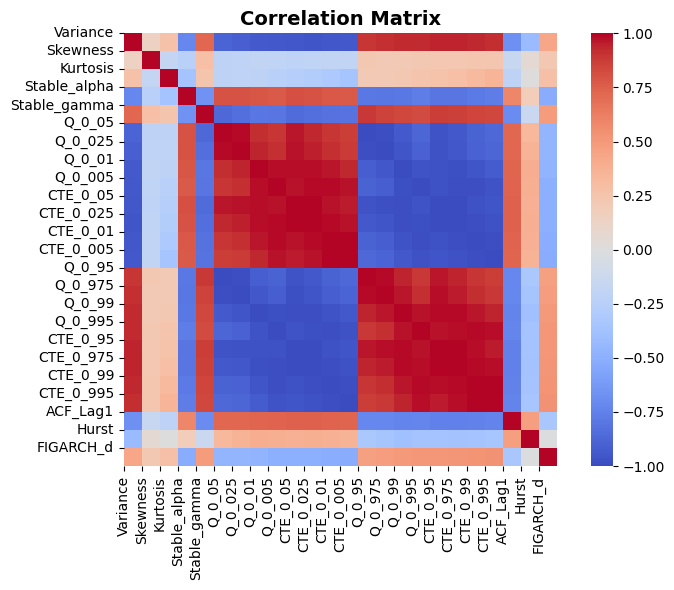

In [3]:
corr_matrix = np.corrcoef(X, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontsize=14, fontweight=1000)

plt.xticks(ticks=np.arange(len(selected_columns)), labels=selected_columns, rotation=90)
plt.yticks(ticks=np.arange(len(selected_columns)), labels=selected_columns, rotation=0)

plt.tight_layout()
plt.savefig('Results/Correlation Matrix.png', dpi=144, transparent=True)
plt.show()

### KMO test

In [4]:
kmo_all, kmo_model = calculate_kmo(X)
print("KMO overall:", kmo_model)

KMO overall: 0.8854149753562718


/opt/homebrew/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


### Factors-Eigenvalue Scree Plot

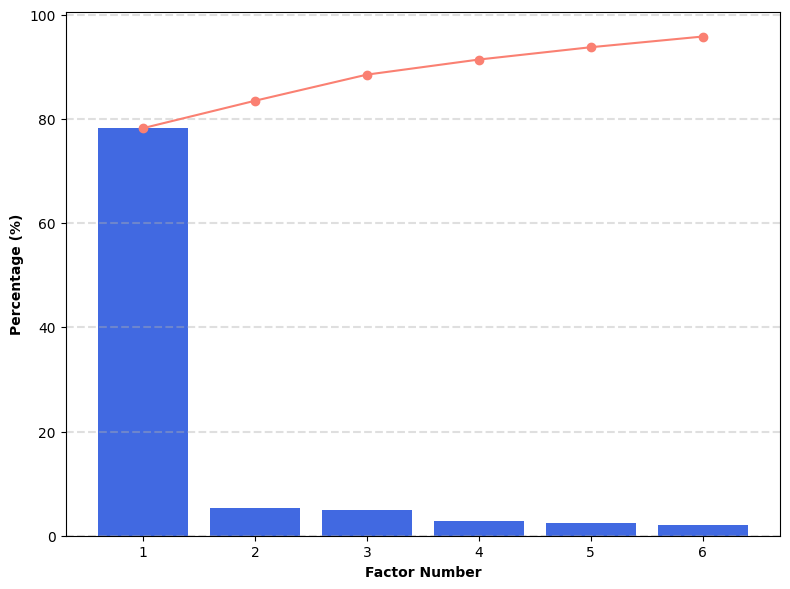

In [5]:
fa = FactorAnalyzer(n_factors=6, method='principal', rotation='varimax')
fa.fit(X)

ev, v = fa.get_eigenvalues()

ev_percent = ev / ev.sum() * 100
cumulative_var = np.cumsum(ev_percent)

ev_percent = ev_percent[:6]
cumulative_var = cumulative_var[:6]

plt.figure(figsize=(8, 6))
x_labels = range(1, 7)

plt.bar(x_labels, ev_percent, color='royalblue')
plt.plot(x_labels, cumulative_var, 'o-', color='salmon')

# plt.title('Scree Plot', fontsize=14, fontweight='heavy')
plt.xlabel('Factor Number', fontsize=10, fontweight='heavy')
plt.ylabel('Percentage (%)', fontsize=10, fontweight='heavy')
plt.xticks(x_labels)
plt.grid(axis='y', linewidth=1.5, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('Results/Scree Plot.png', dpi=144, transparent=True)
plt.show()

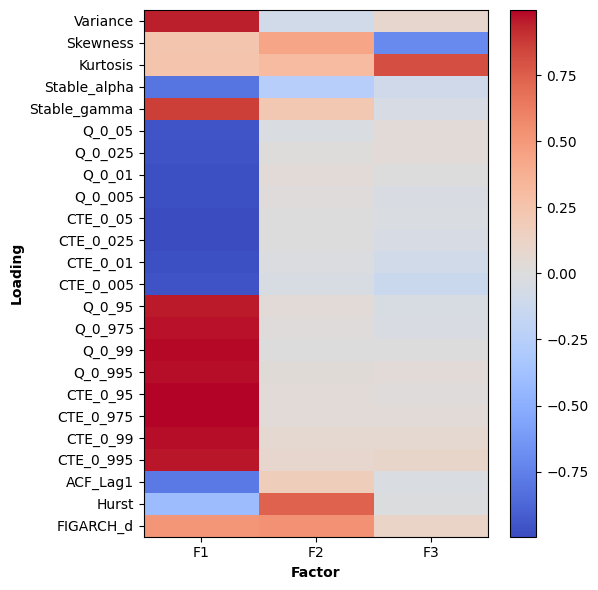

In [213]:
fa3 = FactorAnalyzer(n_factors=3, method='principal', rotation='varimax')
fa3.fit(X)
loadings = fa3.loadings_

plt.figure(figsize=(6, 6))
plt.imshow(loadings, cmap='coolwarm', aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Factor', fontsize=10, fontweight='heavy')
plt.ylabel('Loading', fontsize=10, fontweight='heavy')
plt.xticks(ticks=np.arange(loadings.shape[1]), labels=[f'F{i+1}' for i in range(loadings.shape[1])])
plt.yticks(ticks=np.arange(loadings.shape[0]), labels=numeric_columns)
plt.tight_layout()
plt.savefig('Results/3-Factors Loading.png', dpi=144, transparent=True)
plt.show()

In [214]:
variance_info = fa3.get_factor_variance()
print("Variance explained by each factor:", np.round(variance_info[1], 4))
print("Cumulative variance explained:    ", np.round(variance_info[2], 4))

Variance explained by each factor: [0.7804 0.0536 0.0513]
Cumulative variance explained:     [0.7804 0.834  0.8853]


### Asset Classes Profile Based on the Averages of the 24 Indicators.

In [215]:
factors_avg = data.groupby("Type").mean(numeric_only=True).T
factors_avg = factors_avg[["Crypto", "Stock", "Bond", "Exchange Rate", "Commodity", "Real Estate"]]
factors_avg.iloc[0] = factors_avg.iloc[0] * 1000
factors_avg.to_csv('Results/Factors Average.csv')
display(factors_avg.round(4))

Type,Crypto,Stock,Bond,Exchange Rate,Commodity,Real Estate
Variance,65.7050,0.3799,1.1142,0.0270,0.6122,0.1807
Skewness,0.7345,-0.6042,-0.1753,-0.1944,-0.4173,-0.4375
Kurtosis,64.6644,16.7224,23.9398,4.9989,8.0894,7.3610
Stable_alpha,1.1779,1.5149,1.4012,1.5962,1.5796,1.5890
Stable_gamma,0.0430,0.0090,0.0110,0.0028,0.0110,0.0072
Q_0_05,-0.2252,-0.0277,-0.0365,-0.0077,-0.0327,-0.0213
Q_0_025,-0.3553,-0.0371,-0.0500,-0.0097,-0.0432,-0.0282
Q_0_01,-0.6046,-0.0517,-0.0749,-0.0127,-0.0575,-0.0369
Q_0_005,-0.8501,-0.0662,-0.0940,-0.0149,-0.0703,-0.0434
CTE_0_05,-0.4808,-0.0447,-0.0617,-0.0109,-0.0500,-0.0321


In [216]:
x_min, x_max, y_min, y_max = -5, 18, -4, 8

Processing Tail_Memory:  69%|██████▉   | 1201/1731 [29:11<12:52,  1.46s/it] 


KeyboardInterrupt: 

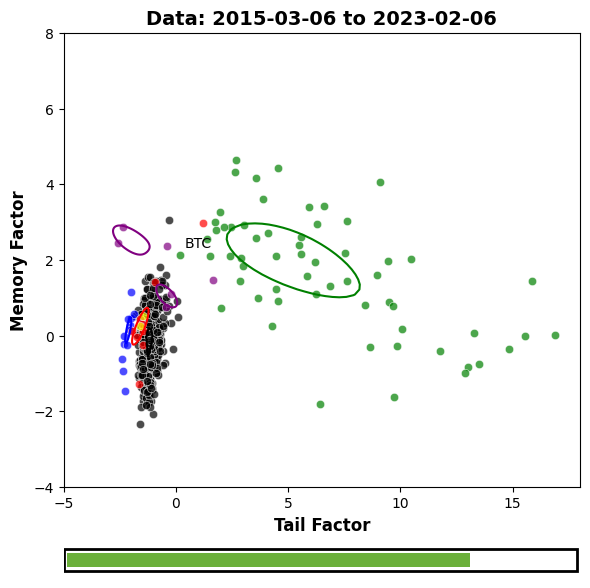

In [219]:
input_folder = "Factors/"
base_output_folder = "Results/Monthly DFA/"
os.makedirs(base_output_folder, exist_ok=True)

files = sorted([f for f in os.listdir(input_folder) if f.endswith('.csv')])
df_latest = pd.read_csv(os.path.join(input_folder, files[-1]))
X_latest = StandardScaler().fit_transform(df_latest.select_dtypes(include=['number']))
pca = PCA(n_components=3).fit(X_latest)

pca_names = ["Tail", "Memory", "Moment"]
factor_pairs = [(0,1), (0,2), (1,2)]  # (PC1, PC2), (PC1, PC3), (PC2, PC3)

color_mapping = {
    'Crypto': 'green',
    'Stock': 'black',
    'Exchange Rate': 'blue',
    'Commodity': 'red',
    'Bond': 'purple',
    'Real Estate': 'yellow'
}

all_dates = []
for file in files:
    df = pd.read_csv(os.path.join(input_folder, file))
    all_dates.append(pd.to_datetime(df['Date'].iloc[0]))

all_dates = sorted(all_dates)
start_date = pd.to_datetime("2015-03-06")
latest_date = all_dates[-1]

for i, j in factor_pairs:
    folder_name = f"{pca_names[i]}_{pca_names[j]}"
    output_folder = os.path.join(base_output_folder, folder_name)
    os.makedirs(output_folder, exist_ok=True)

    for file in tqdm(files, desc=f"Processing {folder_name}"):
        df = pd.read_csv(file_path := os.path.join(input_folder, file))
        X_scaled = StandardScaler().fit_transform(df.select_dtypes(include=['number']))
        X_pca = pca.transform(X_scaled)

        df['PC1'], df['PC2'], df['PC3'] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]
        df['X'], df['Y'] = df[f'PC{i+1}'], df[f'PC{j+1}']  # The X axis and Y axis correspond to PCA components.

        current_date = pd.to_datetime(df['Date'].iloc[0])

        progress_ratio = (current_date - pd.to_datetime("2018-06-29")).days / (latest_date - pd.to_datetime("2018-06-29")).days
        start_rgb = np.array([237, 109, 81])
        end_rgb = np.array([50, 205, 50])
        current_rgb = (1 - progress_ratio) * start_rgb + progress_ratio * end_rgb
        current_rgb = tuple(current_rgb / 255)

        plt.figure(figsize=(6, 6))

        for asset_type, color in color_mapping.items():
            subset = df[df['Type'] == asset_type]

            sns.scatterplot(data=subset, x="X", y="Y", color=color, alpha=0.7, label=asset_type)

            if len(subset) > 5:
                sns.kdeplot(x=subset["X"], y=subset["Y"], levels=[0.9], color=color, linewidths=1.5, warn_singular=False)

        cc_top = cc_cap.loc[pd.to_datetime(df['Date'].iloc[0])].nlargest(5).index
        cc_top_data = df[df['Asset'].isin(cc_top)]
        cc_top_symbol = cc_list.set_index('id').loc[cc_top_data['Asset'], 'symbol'].str.upper().tolist()

        for (_, row), symbol in zip(cc_top_data.iterrows(), cc_top_symbol):
            if x_min <= row['X'] <= x_max and y_min <= row['Y'] <= y_max:
                plt.text(row['X'] + 0.2, row['Y'] + 0.2, symbol, fontsize=10, fontweight=100, color='black')

        plt.title(f"Data: 2015-03-06 to {df['Date'].iloc[0]}", fontsize=14, fontweight='heavy')
        plt.xlabel(f"{pca_names[i]} Factor", fontsize=12, fontweight='heavy')
        plt.ylabel(f"{pca_names[j]} Factor", fontsize=12, fontweight='heavy')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.legend().set_visible(False)

        ax = plt.gca()
        ax_time = ax.inset_axes([0, -0.2, 1, 0.08])
        ax_time.set_xlim([start_date, latest_date])
        ax_time.set_ylim([0, 1])
        ax_time.barh(y=0.5, width=(latest_date - start_date).days-20, left=start_date, height=0.6, color="white", edgecolor="black", linewidth=2)
        ax_time.barh(y=0.5, width=(current_date - start_date).days-60, left=start_date+timedelta(days=25), height=0.4, color=current_rgb)
        ax_time.set_xticks([])
        ax_time.set_yticks([])
        ax_time.set_frame_on(False)

        plt.tight_layout()
        image_path = os.path.join(output_folder, f"{os.path.splitext(file)[0]}.png")
        plt.savefig(image_path, dpi=144, transparent=True)
        plt.close()

In [55]:
for i, j in factor_pairs:
    folder_name = f"{pca_names[i]}_{pca_names[j]}"
    image_folder = os.path.join(base_output_folder, folder_name)
    png_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])

    frames = []
    for png_file in png_files:
        img = Image.open(png_file).convert("RGBA")
        alpha = img.getchannel("A")

        img = img.convert("RGB").convert("P", palette=Image.ADAPTIVE, colors=256, dither=Image.NONE)

        transparency = 255
        for x in range(img.width):
            for y in range(img.height):
                if alpha.getpixel((x, y)) == 0:
                    transparency = img.getpixel((x, y))
                    break
            if transparency != 255:
                break

        frames.append(img)

    gif_name = f"PCA {folder_name}.gif"
    gif_path = os.path.join("Results", gif_name)

    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=150,
        loop=0,
        transparency=transparency,
        disposal=2,
        optimize=False
    )

### Factor Loading Plot

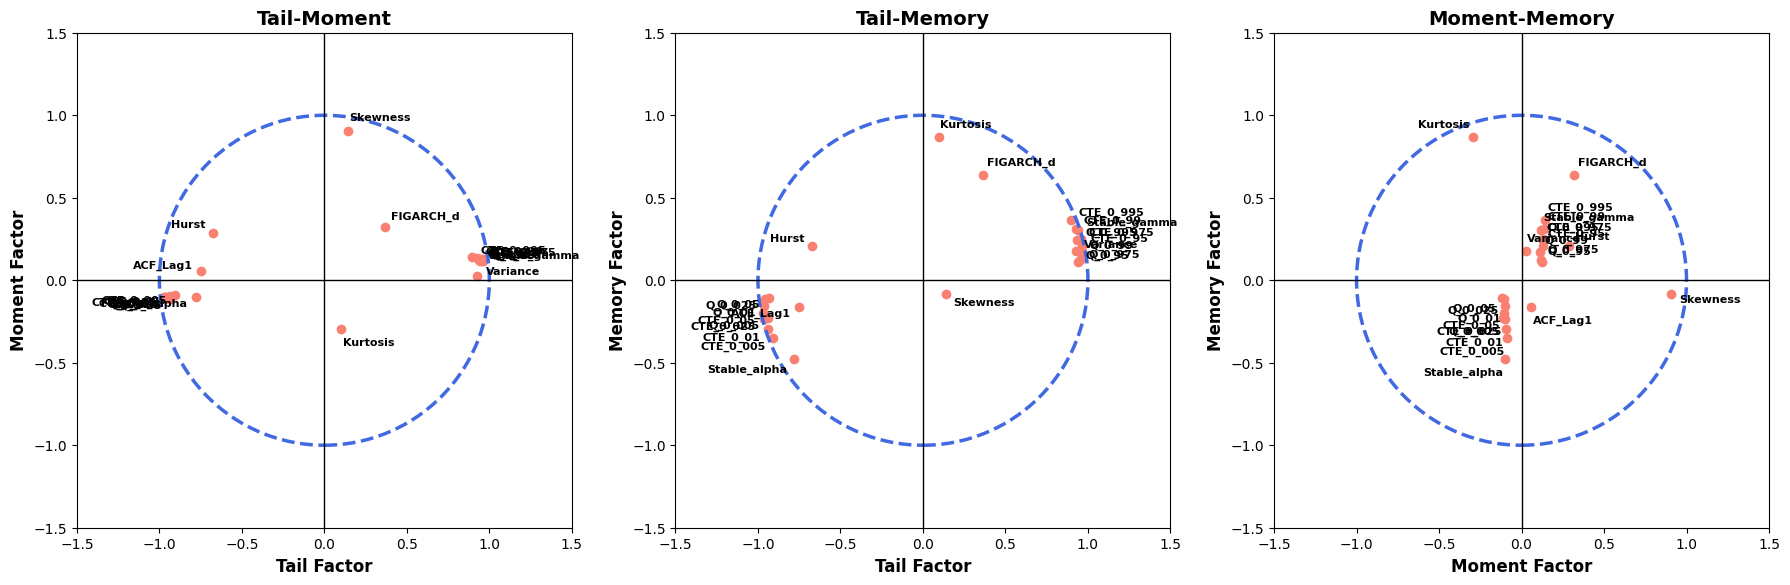

In [ ]:
loadings_df = pd.DataFrame(loadings, index=numeric_columns, columns=[f"{name} Factor" for name in pca_names])

pairs = [
    (f"{pca_names[0]} Factor", f"{pca_names[2]} Factor", f"Loading {pca_names[0]}_{pca_names[2]}.png"),
    (f"{pca_names[0]} Factor", f"{pca_names[1]} Factor", f"Loading {pca_names[0]}_{pca_names[1]}.png"),
    (f"{pca_names[2]} Factor", f"{pca_names[1]} Factor", f"Loading {pca_names[2]}_{pca_names[1]}.png")
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (x_name, y_name, filename) in zip(axes, pairs):
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    ax.scatter(loadings_df[x_name], loadings_df[y_name], color='salmon')

    for label, (x_pos, y_pos) in loadings_df[[x_name, y_name]].iterrows():
        norm = np.sqrt(x_pos**2 + y_pos**2)
        x_offset = (x_pos / norm) * 0.05
        y_offset = (y_pos / norm) * 0.05
        ax.text(x_pos + x_offset, y_pos + y_offset, label, fontsize=8, fontweight='heavy',
                ha='right' if x_pos < 0 else 'left', va='top' if y_pos < 0 else 'bottom')

    ax.set_xlabel(x_name, fontsize=12, fontweight='heavy')
    ax.set_ylabel(y_name, fontsize=12, fontweight='heavy')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.add_patch(plt.Circle((0, 0), 1, color='royalblue', fill=False, linestyle='dashed', linewidth=2.5))
    ax.set_title(f"{x_name.split()[0]}-{y_name.split()[0]}", fontsize=14, fontweight='heavy')

    fig_single, ax_single = plt.subplots(figsize=(6, 6))
    ax_single.axhline(0, color='black', linewidth=1)
    ax_single.axvline(0, color='black', linewidth=1)
    ax_single.scatter(loadings_df[x_name], loadings_df[y_name], color='salmon')
    for label, (x_pos, y_pos) in loadings_df[[x_name, y_name]].iterrows():
        norm = np.sqrt(x_pos**2 + y_pos**2)
        x_offset = (x_pos / norm) * 0.05
        y_offset = (y_pos / norm) * 0.05
        ax_single.text(x_pos + x_offset, y_pos + y_offset, label, fontsize=8, fontweight='heavy',
                       ha='right' if x_pos < 0 else 'left', va='top' if y_pos < 0 else 'bottom')
    ax_single.set_xlabel(x_name, fontsize=10, fontweight='heavy')
    ax_single.set_ylabel(y_name, fontsize=10, fontweight='heavy')
    ax_single.set_xlim(-1.5, 1.5)
    ax_single.set_ylim(-1.5, 1.5)
    ax_single.set_aspect('equal')
    ax_single.add_patch(plt.Circle((0, 0), 1, color='royalblue', fill=False, linestyle='dashed', linewidth=2.5))
    fig_single.tight_layout()
    plt.savefig(f"Results/{filename}", dpi=144, transparent=True)
    plt.close(fig_single)

plt.tight_layout()
plt.show()

### Asset Classification

In [67]:
df['Label'] = df['Type'].apply(lambda x: 1 if x == 'Crypto' else 0)
display(df)

,Date,Asset,Type,Q_0_005,Q_0_01,Q_0_025,Q_0_05,Q_0_95,Q_0_975,Q_0_99,...,Skewness,Kurtosis,ACF_Lag1,Hurst,PC1,PC2,PC3,X,Y,Label
0,2025-01-29,skycoin,Crypto,-0.938031,-0.501965,-0.234449,-0.155471,0.147422,0.248640,0.486672,...,1.210786,78.586410,-0.520632,0.491069,8.427669,2.212631,2.179579,2.212631,2.179579,1
1,2025-01-29,litedoge,Crypto,-1.620815,-1.427397,-0.887520,-0.572868,0.581479,0.805235,1.278920,...,0.320465,62.089829,-0.404222,0.387682,21.106298,-0.755282,-0.850311,-0.755282,-0.850311,1
2,2025-01-29,iota,Crypto,-0.245439,-0.196149,-0.154998,-0.107419,0.107922,0.149095,0.219852,...,0.177102,9.170279,0.045544,0.559793,1.002221,-0.108833,1.419240,-0.108833,1.419240,1
3,2025-01-29,bitcoin-plus,Crypto,-0.735083,-0.602276,-0.430956,-0.306141,0.324054,0.432552,0.603900,...,0.088927,6.237856,-0.321282,0.408298,7.513028,-2.012685,-1.457823,-2.012685,-1.457823,1
4,2025-01-29,infinitecoin,Crypto,-1.642583,-1.466773,-1.077627,-0.503692,0.480618,1.149804,1.609109,...,0.712771,12.904377,-0.349573,0.330936,20.829993,-2.169271,-0.677597,-2.169271,-0.677597,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,2025-01-29,USGG10YR Index,Bond,-0.128346,-0.078791,-0.055716,-0.042341,0.041261,0.058679,0.082912,...,0.226981,37.820209,-0.088619,0.585761,-0.641040,0.700439,1.401445,0.700439,1.401445,0
722,2025-01-29,QW5XX Index,Bond,-0.008037,-0.006338,-0.004238,-0.003206,0.003178,0.004470,0.005737,...,-0.551557,10.880757,0.178586,0.666097,-2.664975,0.818172,1.989675,0.818172,1.989675,0
723,2025-01-29,LF98TRUU Index,Bond,-0.013113,-0.008926,-0.006061,-0.004242,0.004333,0.006134,0.009325,...,-1.392344,27.434954,0.387259,0.616737,-2.789923,1.300000,1.364882,1.300000,1.364882,0
724,2025-01-29,SX86E Index,Real Estate,-0.046089,-0.038995,-0.029557,-0.023633,0.020200,0.027757,0.038965,...,-0.384378,7.487641,0.014419,0.546016,-1.599531,0.212404,0.767888,0.212404,0.767888,0


#### SVM

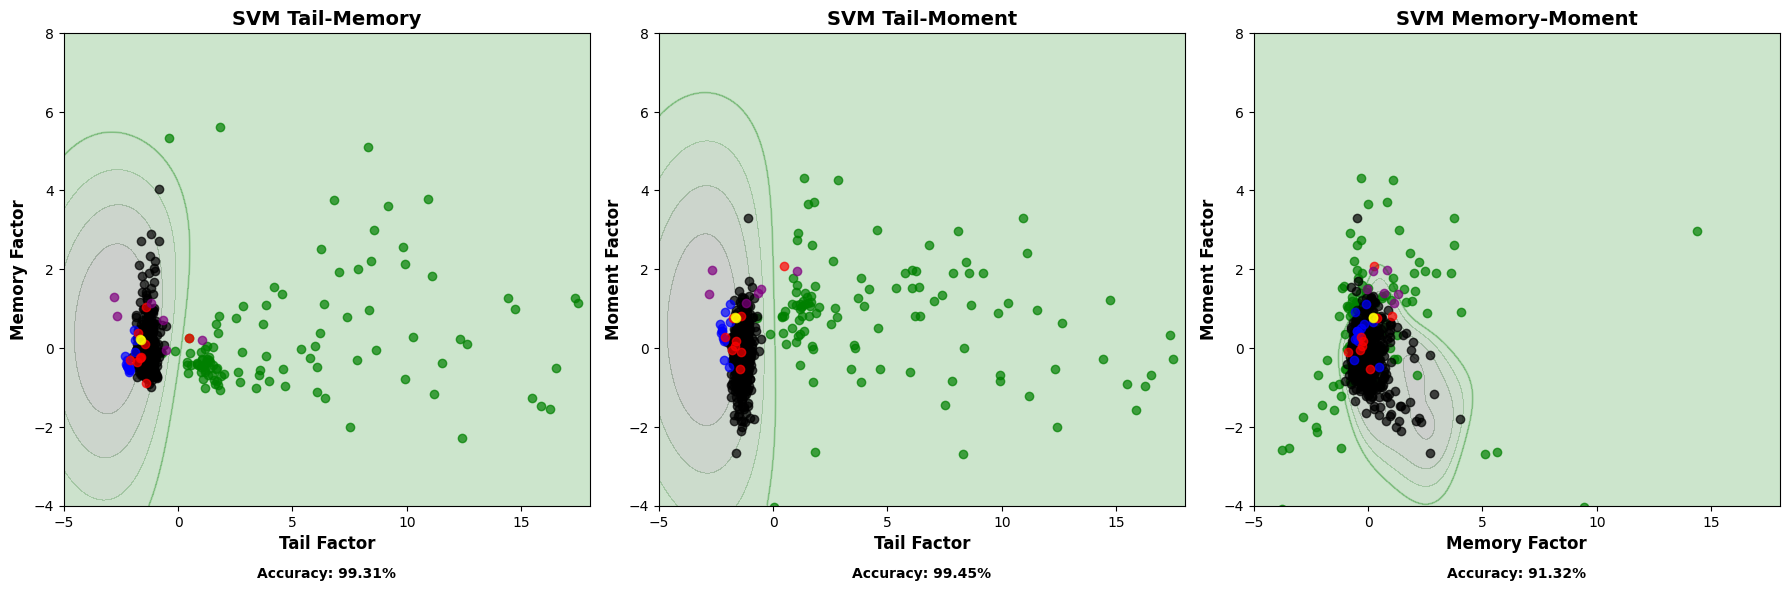

In [ ]:
pairs_svm = [
    (f"PC1", f"PC2", f"SVM {pca_names[0]}_{pca_names[1]}.png"),
    (f"PC1", f"PC3", f"SVM {pca_names[0]}_{pca_names[2]}.png"),
    (f"PC2", f"PC3", f"SVM {pca_names[1]}_{pca_names[2]}.png")
]
label_map = {"PC1": pca_names[0], "PC2": pca_names[1], "PC3": pca_names[2]}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (x_name, y_name, filename) in zip(axes, pairs_svm):
    X_svm = df[[x_name, y_name]].values
    y = df['Label'].values

    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_model.fit(X_svm, y)

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 5), cmap=LinearSegmentedColormap.from_list("G_B", ["black", "green"]), alpha=0.2)
    ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors='green', alpha=0.2)
    ax.contour(xx, yy, Z, levels=[0], colors='green', alpha=0.2)

    for asset_type, color in color_mapping.items():
        subset = df[df['Type'] == asset_type]
        ax.scatter(subset[x_name], subset[y_name], color=color, alpha=0.7, label=asset_type)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(f"{label_map[x_name]} Factor", fontsize=12, fontweight='heavy')
    ax.set_ylabel(f"{label_map[y_name]} Factor", fontsize=12, fontweight='heavy')
    ax.set_title(f"SVM {label_map[x_name]}-{label_map[y_name]}", fontsize=14, fontweight='heavy')

    acc = accuracy_score(y, svm_model.predict(X_svm))
    ax.text(0.5, -0.13, f"Accuracy: {acc:.2%}", fontsize=10, fontweight='heavy',
            transform=ax.transAxes, ha='center', va='top')

    fig_single, ax_single = plt.subplots(figsize=(6, 6))
    ax_single.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 5), cmap=LinearSegmentedColormap.from_list("G_B", ["black", "green"]), alpha=0.2)
    ax_single.contourf(xx, yy, Z, levels=[0, Z.max()], colors='green', alpha=0.2)
    ax_single.contour(xx, yy, Z, levels=[0], colors='green', alpha=0.2)

    for asset_type, color in color_mapping.items():
        subset = df[df['Type'] == asset_type]
        ax_single.scatter(subset[x_name], subset[y_name], color=color, alpha=0.7, label=asset_type)

    ax_single.set_xlim(x_min, x_max)
    ax_single.set_ylim(y_min, y_max)
    ax_single.set_xlabel(f"{label_map[x_name]} Factor", fontsize=10, fontweight='heavy')
    ax_single.set_ylabel(f"{label_map[y_name]} Factor", fontsize=10, fontweight='heavy')
    ax_single.set_title(f"SVM {label_map[x_name]}-{label_map[y_name]}", fontsize=14, fontweight='heavy')
    fig_single.tight_layout()
    plt.savefig(f"Results/{filename}", dpi=144, transparent=True)
    plt.close(fig_single)

plt.tight_layout()
plt.show()

### K-Means

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


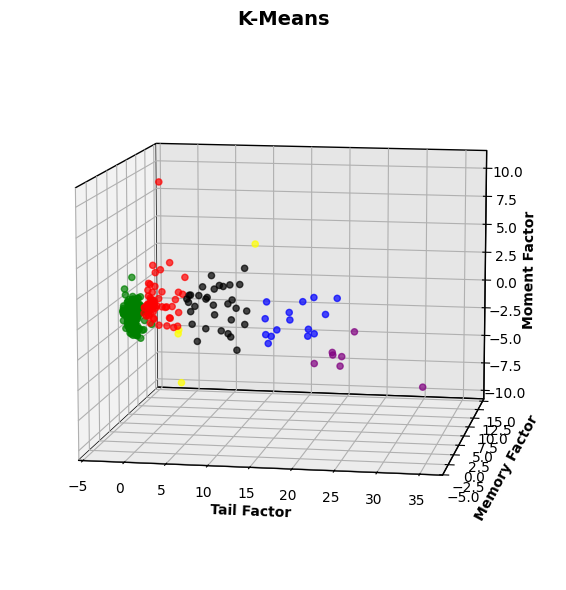

In [ ]:
df["Cluster"] = df["Type"].map(color_mapping)

X_kmeans = df[["PC1", "PC2", "PC3"]].values
kmeans_model = KMeans(n_clusters=6, random_state=0)
kmeans_model.fit(X_kmeans)
df["kmeans"] = kmeans_model.labels_

kmeans_color_map = {0: 'green', 1: 'black', 2: 'blue', 3: 'red', 4: 'purple', 5: 'yellow'}

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=-80)

for cluster_id in sorted(df["kmeans"].unique()):
    subset = df[df["kmeans"] == cluster_id]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"],
               color=kmeans_color_map[cluster_id],
               label=f"KMeans {cluster_id}", alpha=0.7)

ax.set_xlabel(f"{pca_names[0]} Factor", fontsize=10, fontweight='heavy')
ax.set_ylabel(f"{pca_names[1]} Factor", fontsize=10, fontweight='heavy')
ax.set_zlabel(f"{pca_names[2]} Factor", fontsize=10, fontweight='heavy')
ax.set_title("K-Means", fontsize=14, fontweight='heavy')

fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.xaxis.pane.set_edgecolor('black')
ax.xaxis.pane.set_alpha(1)
ax.yaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_alpha(1)
ax.zaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_alpha(1)

ax.grid(True)

acc = accuracy_score(df["Type"], df["kmeans"])

from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(df["Type"], df["kmeans"])

# fig.text(0.5, 0.01, f"Adjusted Rand Index (ARI): {ari:.4f}", ha='center', va='center', fontsize=10, fontweight='heavy')

plt.tight_layout()
plt.show()